# Multiclass image segmentation for different loss functions(Dice loss, Focal loss, Total loss = (Summation of Dice and focal loss) ) 

**The main purpose of this notebook is to show the pipeline for using the above loss functions in Multiclass semantic image segmentation**

In [93]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

import tensorflow.python.keras as keras

import matplotlib as mpl
from matplotlib import patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import pandas as pd 
import os
from matplotlib.pyplot import imread
#ggplot
plt.style.use('classic')
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical   
import cv2
import gc
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from scipy import io, misc
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# from keras.utils import np_utils
import segmentation_models as sm
from segmentation_models import get_preprocessing, Unet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss, jaccard_loss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow import keras



from keras.metrics import MeanIoU
from keras import backend as K
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler, LambdaCallback
from keras.optimizers import Adam

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import PIL
import skimage
import torchvision.transforms as T
from PIL import Image

In [2]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)
tf.compat.v1.GPUOptions(allow_growth=False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Num GPUs Available:  1


In [3]:
# !git clone https://github.com/bearpaw/clothing-co-parsing.git
# !echo pwd
# %env SM_FRAMEWORK=tf.keras
# !pip3 install segmentation_models

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.
pwd
env: SM_FRAMEWORK=tf.keras


# Image processing and agumentation for segmentation

In [218]:
IMAGE_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/Face_Segments/img'
MASK_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/mask_mat'
#sort the images and masks
image_dir = sorted(os.listdir(IMAGE_PATH))
mask_dir = sorted(os.listdir(MASK_PATH))


In [429]:
def process_x(files,dsize = (256,256)):
    


  x = []
  for img in files:
      
      img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
      x.append(img)
    
  return np.array(x).astype("float32")     

def process_y(files,dsize = (256,256),cat = False , n_classes = 5 ):
    
    masks = []
    for img in files:
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(res)
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    if(cat):
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        return y_train_cat
    else:
        return train_masks_input


def process_x1(files,dsize = (256,256) ):

  # files = [i for i in files] 
  
  x = []
  X = []
  for img in files:
    img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
    x.append(img)
  for i in x :
      image = tf.cast(tf.convert_to_tensor(i), tf.float32)
      X.append(image)
  return X 

def process_y1(files,dsize = (256,256) , cat = False , n_classes = 5 ):
    
    masks = []
    Y = []
    for img in files:
        
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(tf.convert_to_tensor(res))
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    if(cat == False):

        # train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        for mask in  train_masks_encoded_original_shape:
            m = tf.expand_dims(tf.convert_to_tensor(mask), axis=-1)
            m = tf.cast(m, tf.float32)
            Y.append(m)
        return Y
    else:
        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        for mask in y_train_cat:
             m = tf.cast(tf.convert_to_tensor(mask), tf.float32)
             Y.append(m)
        return Y 




def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask





def further_process(X_train,y_train,X_val,y_val,BATCH = 4 ):
    
    train_X = tf.data.Dataset.from_tensor_slices(X_train)
    val_X = tf.data.Dataset.from_tensor_slices(X_val)

    train_y = tf.data.Dataset.from_tensor_slices(y_train)
    val_y = tf.data.Dataset.from_tensor_slices(y_val)

    # print(train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec)

    train = tf.data.Dataset.zip((train_X, train_y))
    val = tf.data.Dataset.zip((val_X, val_y))

    # perform augmentation on train data only

    a = train.map(brightness)
    b = train.map(gamma)
    c = train.map(hue)
    # d = train.map(crop)
    e = train.map(flip_hori)
    f = train.map(flip_vert)
    g = train.map(rotate)

    train = train.concatenate(a)
    train = train.concatenate(b)
    train = train.concatenate(c)
    # train = train.concatenate(d)
    train = train.concatenate(e)
    train = train.concatenate(f)
    train = train.concatenate(g)

    AT = tf.data.AUTOTUNE
    BUFFER = len(X_train) + len(X_val)
    print("BUFFER " , BUFFER )

    # STEPS_PER_EPOCH = len(X_train)//BATCH
    # VALIDATION_STEPS = len(X_val)//BATCH

    # print("STEPS_PER_EPOCH " , STEPS_PER_EPOCH)
    # print("VALIDATION_STEPS " , VALIDATION_STEPS)



    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)
    val = val.batch(BATCH)
    print("train ",train)
    print("val " ,val)

    return (train,val)

060002_4_028450_FEMALE_301673045657.mat
060003_4_028451_MALE_651673045658.mat
060004_4_028452_MALE_311673045647.mat
060005_4_023834_FEMALE_331673045643.mat
060006_4_015021_FEMALE_391673045638.mat
060009_4_019350_FEMALE_211673045667.mat
060012_4_020004_MALE_271673045666.mat
060013_4_014380_MALE_341673045655.mat
060014_4_016695_MALE_431673045642.mat
060019_4_028457_MALE_331673045653.mat
060020_3_024801_NONE_281673045650.mat
060027_4_025986_FEMALE_361673045664.mat
060028_4_022580_NONE_251673045664.mat
060032_4_027166_MALE_281673045654.mat
060033_4_028462_MALE_191673045668.mat
060037_4_028465_FEMALE_231673045639.mat
060038_4_028466_MALE_191673045646.mat
060040_4_015000_FEMALE_391673045640.mat
060043_4_028470_FEMALE_191673045656.mat
060047_4_027403_MALE_251673045665.mat


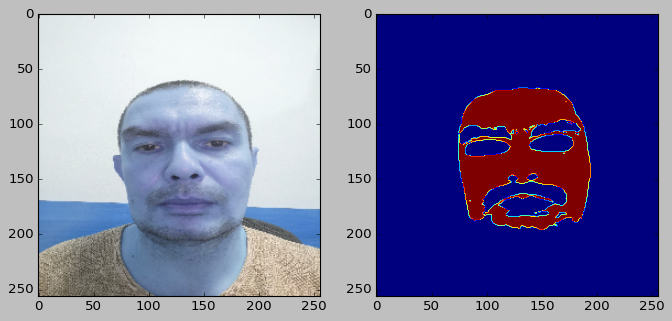

20
20


In [416]:
images =[]
test_images = []
#import sorting directories
import os
from os import listdir
from os.path import isfile, join
last = 0
curr = 0
#sort images
for img in image_dir:

    img = cv2.imread(os.path.join(IMAGE_PATH,img))
    img = cv2.resize(img, (256,256))
    images.append(img)
    
masks = []
skin_color = (212,198,169)
for mask in mask_dir:
    print(mask)
    mask = os.path.join(MASK_PATH,mask)
    file = io.loadmat(mask)
    img = file['M'].astype(np.uint8)
    #create binary mask for skin
    img = np.where(img != skin_color , (0,0,0), img)
    img = np.where(img == skin_color , (255,255,255), img)
    #crop and resize to 256x256
    
    img = np.asarray(img).astype(np.uint8)
    img = cv2.resize(img, (256,256))
    #convert to binary mask
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    masks.append(img)



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[1])
ax[1].imshow(masks[1])
plt.show()
print(len(images))
print(len(masks))

In [417]:
images[0].shape , masks[0].shape

((256, 256, 3), (256, 256))

In [265]:
# Create a mapping between RGB labels and categorical labels
label_mapping = {
    (212,198,169): 'skin',
    (1,79,151): 'eye1',
    (0,0,0): 'eye2',
    (241,140,184): 'lips',
    (141,136,124): 'nostrils',
    (138,137,21): 'eyebrows',
    (105,67,116): 'hair',
    (255,81,46): 'clothes',
    (255,255,255): 'background'

}
print(np.asarray(images).shape)
print(np.asarray(masks).shape)
# h, w = masks[0].shape
# n = len(masks)

(20, 256, 256, 3)
(20, 256, 256, 3)


[  0   4   7  17  20  22  30  32  36  52  60  75  76  92  96  98  99 107
 108 115 119 122 123 127 131 143 152 155 159 161 163 164 173 179 187 195
 197 203 218 223 225 235 236 237 239 242 243 249 252 254 255]
(256, 256, 3)
[  0   4   7  17  20  22  30  32  36  52  60  75  76  92  96  98  99 107
 108 115 119 122 123 127 131 143 152 155 159 161 163 164 173 179 187 195
 197 203 218 223 225 235 236 237 239 242 243 249 252 254 255]


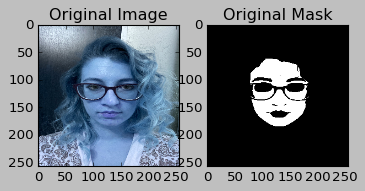

In [228]:

#classes = [ 0  5 19 39 41 42 45 47 55]
mask0 = masks[2]
# mask0_41 = np.where(mask0 != 41 , 0, mask0)

#make figure with mask0 mask0_41 and original image
fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(images[0])
ax[0].set_title("Original Image")
ax[1].imshow(masks[0])
ax[1].set_title("Original Mask")
#print number of classes in mask0
print(np.unique(mask0)) 
#convert all non skin classes to 0
#get class label for skin
skin_class = np.unique(mask0)
print(mask0.shape)
color = (212,198,169)

#print unique colors in mask0
print(np.unique(mask0))
#convert to binary mask for skin

#create binary mask for skin
# mask0_skin = np.where(mask0 != color , 0, mask0)
# mask0_skin = np.where(mask0_skin == color , (255,255,255), mask0_skin)
# plt.imshow(masks[0])
# plt.show()




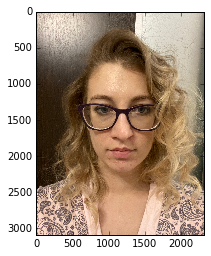

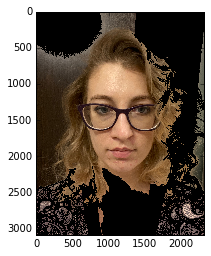

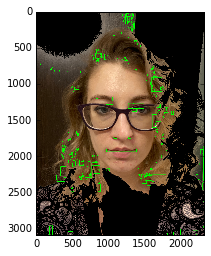

In [70]:
from PIL import Image, ImageEnhance, ImageFilter
image = Image.open(r'/Users/joeljohnson/Desktop/Joel/jan2_segmentation_FaceOnly/Face_Segments/img/060002_4_028450_FEMALE_30.jpg')
image = np.asarray(image)
gausian = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(image)
plt.show()
# Convert the image to grayscale
gray = cv2.cvtColor(gausian, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
threshold, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Find the contours of the foreground objects
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask with the same size as the input image
mask = np.zeros_like(image)

# Fill the contours with white on the mask
cv2.fillPoly(mask, contours, (255, 255, 255))

# Use the mask to remove the background from the image
masked_image = cv2.bitwise_and(image, mask)
plt.imshow(masked_image)
plt.show()

# Load the image
# image = cv2.imread(r'/Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/clothing-co-parsing/photos/0003.jpg')
image = cv2.GaussianBlur(masked_image, (5, 5), 0)
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
threshold, binary = cv2.threshold(gray, 0, 240, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Find the contours of the foreground objects
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and draw a rectangle around the person
for contour in contours:
    if cv2.contourArea(contour) > 30:  # Only select contours with large enough areas
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Show the resulting image
plt.imshow(image)
plt.show()

Parameters for Unet

In [441]:
EPOCHS = 10
BATCH_SIZE = 5
TRAIN_SIZE  = 5
VAL_SIZE = 2
NUM_SAMPLES = 10
LEARING_RATE = 1e-4
MIN_LR = 1e-7
SMOOTH = 1e-10
RND_SEED = 7
KERNEL_INITIALIZER = "he_normal"
KI_2 = "gaussian_normal"
DROPOUT = 0.1

PATIENCE = 2
RLR_FACTOR = 0.2
COOLDOWN = 3

LOAD_OLD_MODEL = False

In [442]:
def give_data(BATCH = 5, n = 10):

    X = process_x1(images[:n])
    y= process_y1(masks[:n], cat = False ,  n_classes = 1 )

    train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                          test_size=0.25, 
                                                          random_state=42
                                                         )
    test_X = process_x(images[n:])
    test_y= process_y(masks[n:] )
    
    train , val = further_process(train_X,train_y, val_X , val_y,BATCH = BATCH)
    
    STEPS_PER_EPOCH = len(train_X)//BATCH
    VALIDATION_STEPS = len(val_X)//BATCH
    
    
    return (train , val,test_X,test_y, STEPS_PER_EPOCH,VALIDATION_STEPS)

In [443]:
train , val,test_X,test_y, STEPS_PER_EPOCH,VALIDATION_STEPS = give_data()

BUFFER  10
train  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
val  <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


/Users/joeljohnson/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Segmentation models is python library with Neural Networks for Image Segmentation based on Keras (Tensorflow) framework

[https://segmentation-models.readthedocs.io/en/latest/tutorial.html](http://)

In [432]:
smooth = SMOOTH
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [347]:
# import segmentation_models as sm
# from segmentation_models.losses import dice_loss, bce_jaccard_loss, bce_dice_loss, categorical_crossentropy
# from segmentation_models.metrics import iou_score

# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true_f = tf.keras.layers.Flatten()(y_true)
#     y_pred_f = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [13]:
# def unet(pretrained_weights = None,input_size = (256,256,3),n = 1 ,loss = dice_loss , metrics=[dice_coef]):
#     KR = tf.keras.regularizers.l2( l=0.001)
#     BR = tf.keras.regularizers.l2(l=0.001)


#     inputs = Input(input_size)
#     # s = inputs
#     # s = Lambda(lambda x: x / 255.0) (inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = tf.keras.layers.Dropout(0.5)(conv4)
#     pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     # drop5 = tf.keras.layers.Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(n, 1, activation = None)(conv9)
#     print(f"input shape is {inputs.shape}")
#     print(f"conv10 shape is {conv10.shape}")
#     model = Model(inputs, conv10)

#     model.compile(optimizer = Adam(learning_rate = 1e-4), loss = dice_loss, metrics=[dice_coef])
    
    
#     return model 

In [433]:
KI = KERNEL_INITIALIZER
DO = DROPOUT
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer=KI)(inputs)
    x = Dropout(DO)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",kernel_initializer=KI)(x)
    x = Dropout(DO)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    inputs = inputs/255.0


    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid", kernel_initializer=KI)(d4)
    # INIT = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='gaussian')
    model = Model(inputs, outputs, name="UNET")
    return model


input_shape = (256, 256, 3)
model = build_unet(input_shape)
# model.summary()


In [444]:
#import gaussian_filter
from  scipy.ndimage import gaussian_filter
""" Seeding """
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)

""" Hyperparameters """

model_path = os.path.join("files", "model_weights.h5")
csv_path = os.path.join("files", "log.csv")


""" Model """
H = 256
W = 256

model = build_unet((H, W, 3))
# model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.compile(loss=dice_loss, optimizer=Adam(LEARING_RATE), metrics=[dice_coef,'accuracy'] )


from keras.callbacks import ModelCheckpoint

model_path = r"/Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/checkpoints/model.h5"
def scheduler(epoch, lr):
    if epoch < 5 :
        return lr
    else:
        return lr * tf.math.exp(-0.1)
        
def append_dice_coef(epoch, logs):
    dice_coef_dict[epoch] = logs['dice_coef']

def append_loss(epoch, logs):
    loss_dict[epoch] = logs['loss']

batch_print_callback = LambdaCallback(
    on_batch_begin=lambda batch,logs: print(batch))
dice_coef_dict = {}
loss_dict = {}

dice_coef_callback = LambdaCallback(on_epoch_end=append_dice_coef)
loss_callback = LambdaCallback(on_epoch_end=append_loss)
epoch_end_callback = LambdaCallback(on_epoch_end=lambda scheduler,  logs: model.optimizer.lr.numpy())
model_checkpoint_callback = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='loss', factor=RLR_FACTOR, patience=PATIENCE, min_lr=MIN_LR, verbose=0,cooldown=COOLDOWN)
csv_logger_callback = CSVLogger(model_path)
lr_scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

callbacks = [
    epoch_end_callback,
    model_checkpoint_callback,
    reduce_lr_callback,
    csv_logger_callback,
    # lr_scheduler_callback,
    batch_print_callback,
    dice_coef_callback,
    loss_callback
]

#choose model starting weights so the mask prediction is a sphere in the middle of the image



if LOAD_OLD_MODEL:
    try :
        weights = model.load_weights(model_path)
        model.set_weights(weights)

        print("Old model weights loaded")
    except IndexError:
        print(IndexError.args)
        print("No old model weights found")
    
model.fit(          
    x=train,
    validation_data=val,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks
    )
model.save_weights(model_path)
# model_dict = model.to_dict()

Epoch 1/10
0
1/1 [==============================] - 3s 3s/step - loss: -0.0438 - dice_coef: 1.0438 - accuracy: 0.3249 - lr: 1.0000e-04
Epoch 2/10
0
1/1 [==============================] - 1s 683ms/step - loss: -0.1220 - dice_coef: 1.1220 - accuracy: 0.3210 - lr: 1.0000e-04
Epoch 3/10
0
1/1 [==============================] - 1s 672ms/step - loss: -0.1548 - dice_coef: 1.1548 - accuracy: 0.3333 - lr: 1.0000e-04
Epoch 4/10
0
1/1 [==============================] - 1s 671ms/step - loss: -0.1919 - dice_coef: 1.1919 - accuracy: 0.3288 - lr: 1.0000e-04
Epoch 5/10
0
1/1 [==============================] - 1s 673ms/step - loss: -0.2331 - dice_coef: 1.2331 - accuracy: 0.3155 - lr: 1.0000e-04
Epoch 6/10
0
1/1 [==============================] - 1s 746ms/step - loss: -0.3036 - dice_coef: 1.3036 - accuracy: 0.3493 - lr: 1.0000e-04
Epoch 7/10
0
1/1 [==============================] - 1s 667ms/step - loss: -0.3738 - dice_coef: 1.3738 - accuracy: 0.3370 - lr: 1.0000e-04
Epoch 8/10
0
1/1 [===================

In [16]:
#get model dictionary
#import keras model to dictionary
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
dictionary = model.get_weights()
#get the weights for the output layer
output = dictionary[-2]
print(output.shape)

(1, 1, 64, 1)


[ 3  3  3 64]
mask shape (3, 3, 64)
(3, 3)


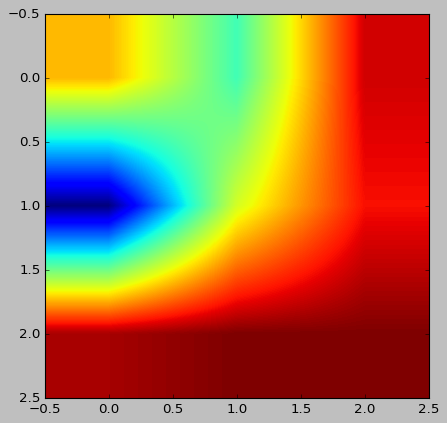

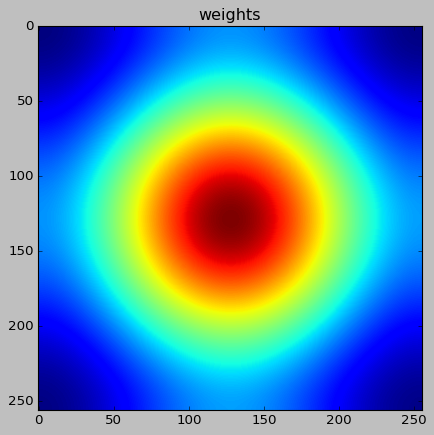

old _weights (3, 3, 3, 64)
new weights (256, 256, 1)
a


In [437]:
old_weights = model.get_weights()
model.set_weights(old_weights)
print(np.asanyarray(old_weights[0].shape))
# print(old_weights)
#find the mask prediction in weights
mask = old_weights[0][:,:,0]
print("mask shape",mask.shape)
mask = np.argmax(mask, axis=-1).squeeze().astype(np.uint8)
print(mask.shape)
plt.imshow(mask)
plt.show()
#choose model starting weights so the mask prediction is a sphere in the middle of the image
weights = np.zeros((256,256,1))
weights[128,128,0] = 1
weights = gaussian_filter(weights, sigma=70)
weights = weights/np.max(weights)
#reshape weights to match model
# weights = np.repeat(weights, 3, axis=1)
# weights = np.expand_dims(weights, axis=0)

plt.imshow(weights)

plt.title("weights")
plt.show()
print(f"old _weights" ,old_weights[0].shape)
print("new weights" ,weights.shape)
#reshape weights to match model
model.load_weights(model_path)
print("a")




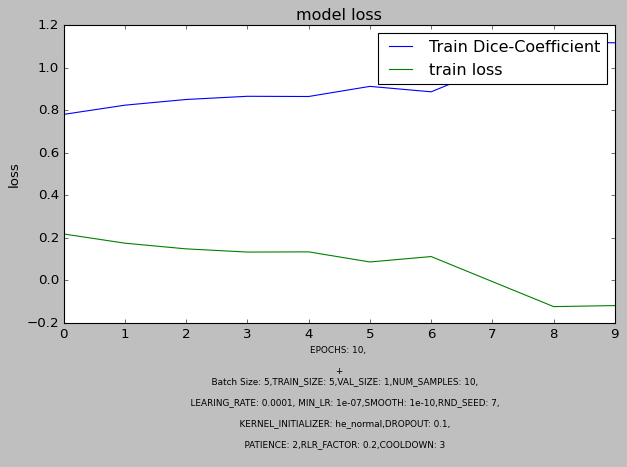


    Batch Size: 5,TRAIN_SIZE: 5,VAL_SIZE: 1,NUM_SAMPLES: 10,

    LEARING_RATE: 0.0001, MIN_LR: 1e-07,SMOOTH: 1e-10,RND_SEED: 7,

    KERNEL_INITIALIZER: he_normal,DROPOUT: 0.1,

    PATIENCE: 2,RLR_FACTOR: 0.2,COOLDOWN: 3
    


KeyError: 'val_loss'

In [438]:
#plot model history
"""README.mdEPOCHS = 100
BATCH_SIZE = 20
TRAIN_SIZE  = 0.75
VAL_SIZE = 0.25
NUM_SAMPLES = 1000
LEARING_RATE = 1e-4
MIN_LR = 1e-7
SMOOTH = 1e-10
RND_SEED = 7
KERNEL_INITIALIZER = "he_normal"
DROPOUT = 0.01
PATIENCE = 2
RLR_FACTOR = 0.2
COOLDOWN = 3
"""
iteration_string = f"""
    Batch Size: {BATCH_SIZE},TRAIN_SIZE: {TRAIN_SIZE},VAL_SIZE: {VAL_SIZE},NUM_SAMPLES: {NUM_SAMPLES},\n
    LEARING_RATE: {LEARING_RATE}, MIN_LR: {MIN_LR},SMOOTH: {SMOOTH},RND_SEED: {RND_SEED},\n
    KERNEL_INITIALIZER: {KERNEL_INITIALIZER},DROPOUT: {DROPOUT},\n
    PATIENCE: {PATIENCE},RLR_FACTOR: {RLR_FACTOR},COOLDOWN: {COOLDOWN}
    """
plt.plot(dice_coef_dict.keys(), dice_coef_dict.values(), label='train')
plt.plot(loss_dict.keys(), loss_dict.values(), label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(f"EPOCHS: {EPOCHS}, \n \n + {iteration_string}", fontsize=8)
plt.legend(['Train Dice-Coefficient', 'train loss'])
# increase padding around the figure
plt.tight_layout()
plt.show()
print(iteration_string)
# plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(f"EPOCHS: {EPOCHS},\n\n + {iteration_string}", fontsize=8)
plt.legend(['Train Dice-Loss', 'Test Dice-Loss'])
# increase padding around the figure
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 470ms/step


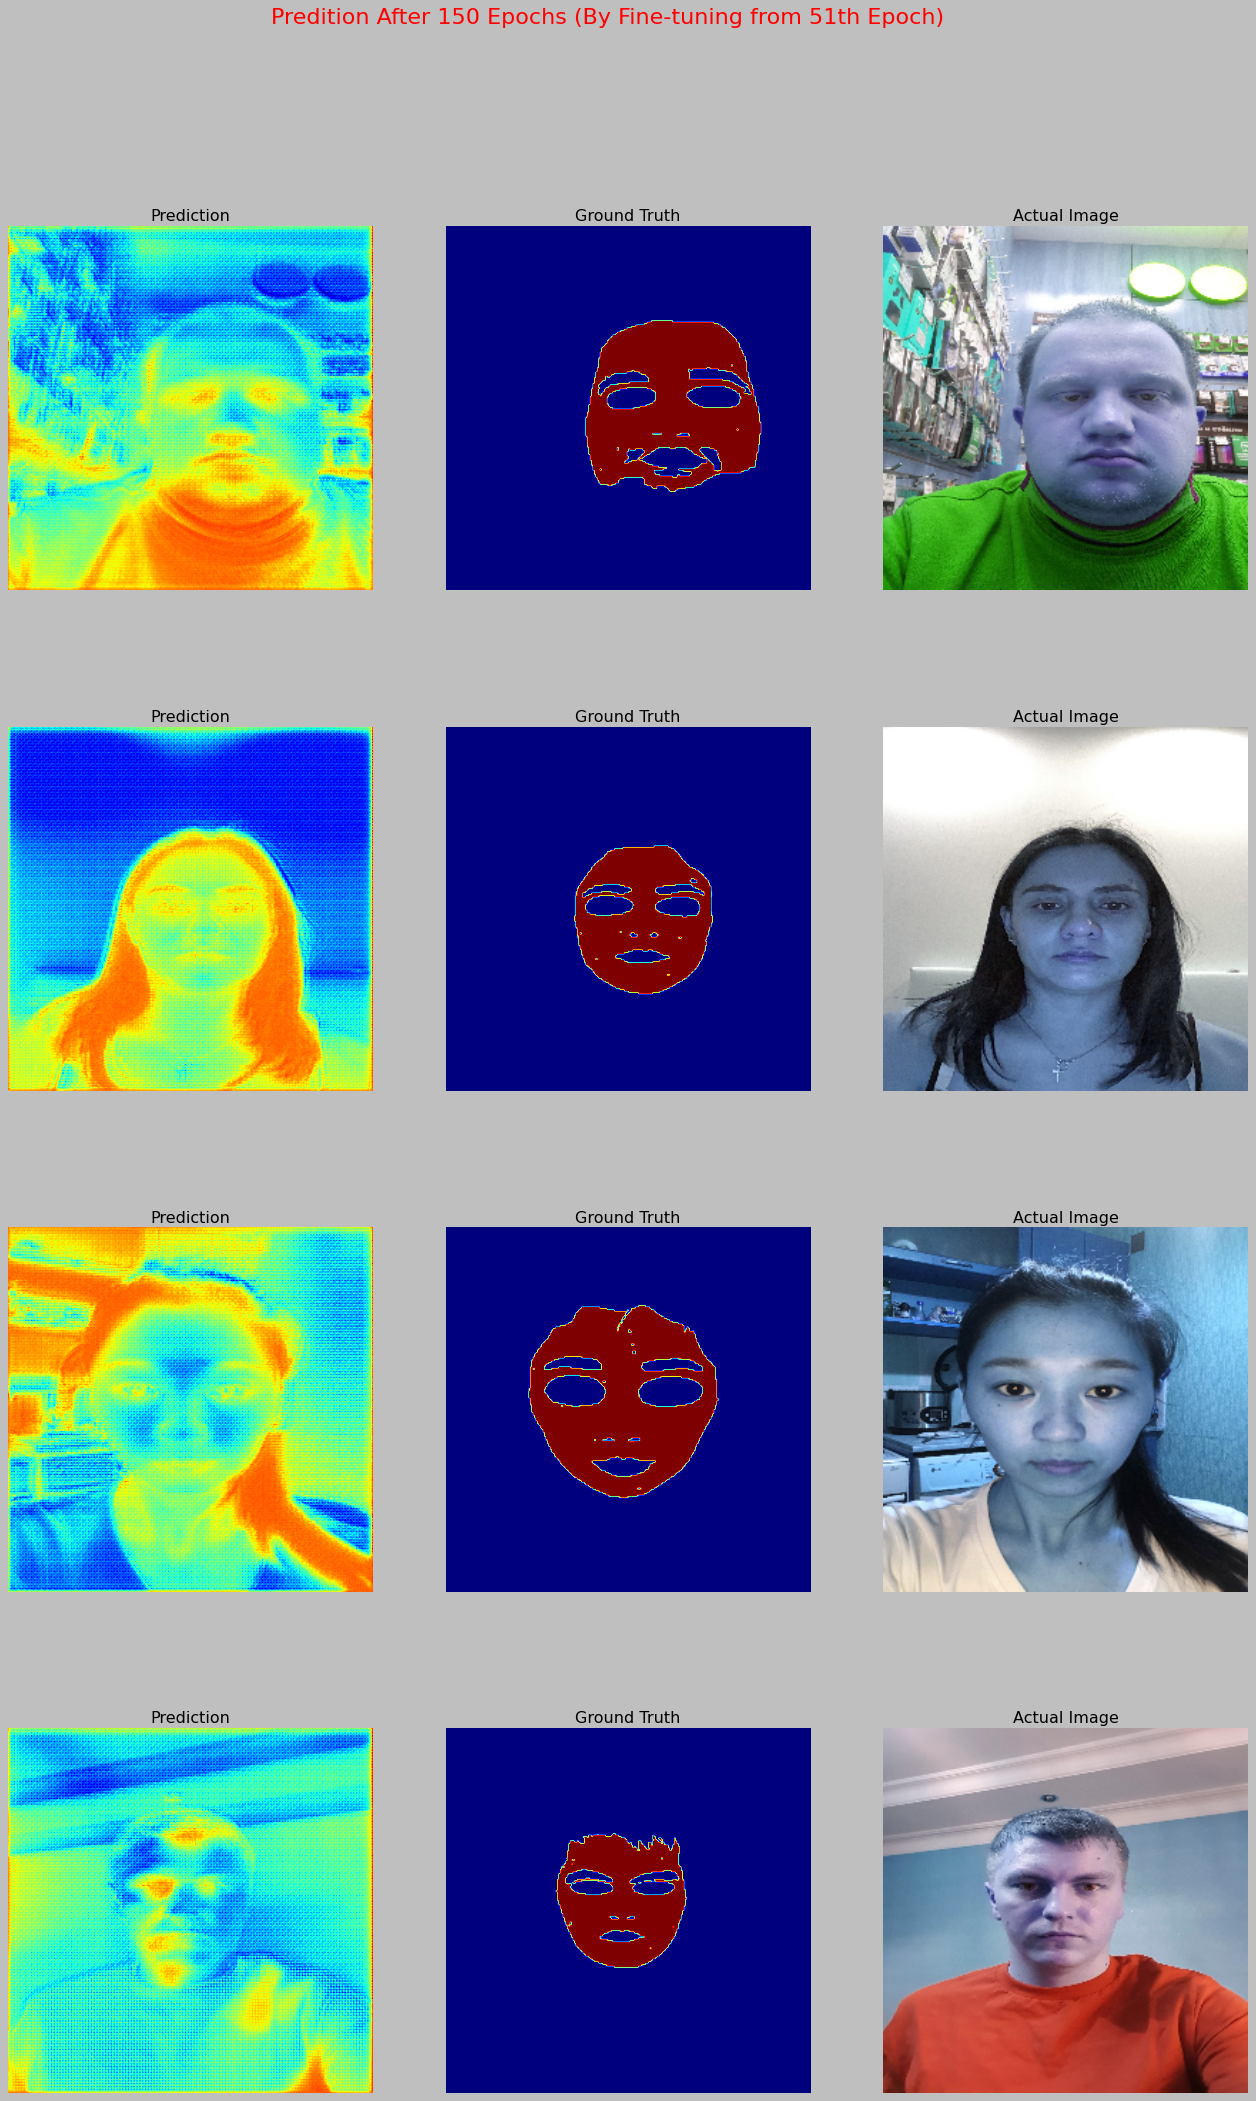

In [445]:



NORM = mpl.colors.Normalize(vmin=0, vmax=1)
# select a validation data batch
img, mask = next(iter(val))
# make prediction

mask = test_y[0:4]
img = test_X[0:4]
pred = model.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    # i = tf.argmax(i, axis=-1)
    # i = np.reshape(i, (256, 256, 1))
    
    plt.imshow(i, cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    # display_segmented_image(i, input_image=img[k], ax=plt.gca())
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)  
plt.show()

Load Model From JSON

In [20]:
from keras.models import load_model
from keras.models import model_from_json
import json

with open('model_in_json.json','r') as f:
    model_json = json.load(f)

model_reload = model_from_json(model_json)
model_reload.load_weights('model_weights.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# model_reload.summary()
model_reload.weights


[<tf.Variable 'conv2d_309/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[-0.4263878 ,  0.10955783, -0.08649163, ..., -0.4363405 ,
            0.08967856,  0.54793286],
          [-0.37798068,  0.05728349, -0.05840633, ...,  0.09118248,
           -0.09005179,  0.11871444],
          [-0.14920887, -0.07300892, -0.11545774, ..., -0.23115447,
            0.39740527,  0.3894607 ]],
 
         [[ 0.5086581 , -0.5264634 , -0.08510263, ..., -0.05491417,
           -0.02616838, -0.5153953 ],
          [ 0.35052952,  0.0477571 ,  0.03173333, ..., -0.09620459,
            0.29902676,  0.08109745],
          [-0.33495453, -0.50026894, -0.5437145 , ...,  0.1710021 ,
            0.08676299,  0.2627676 ]],
 
         [[ 0.44027773,  0.2611263 , -0.3547178 , ..., -0.39875808,
            0.42892522,  0.09951832],
          [-0.1304736 , -0.22008964,  0.42566025, ...,  0.29294345,
           -0.17975718, -0.08604377],
          [ 0.18890475, -0.38253903, -0.34047884, ...,  0.03534298,


(2, 256, 256, 3)
1/1 [==============================] - 0s 456ms/step


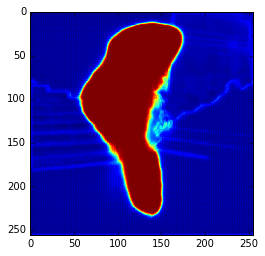

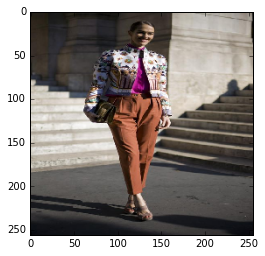

(256, 256, 1)
(256, 256, 3)


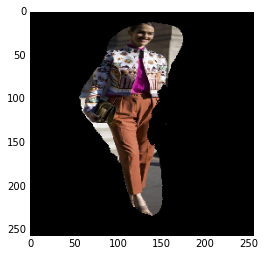

In [ ]:
#load image
transform = T.ToPILImage()



test_set = test_X[:2]
print(test_set.shape)


predictions = model.predict(test_set)
#with gpu

pred_1 = predictions[1]

plt.imshow(pred_1, cmap='jet')
plt.show()
plt.imshow(test_X[1])
plt.show()
#use mask to get skin from image
mask_pred = pred_1
mask_pred = np.where(mask_pred > 0.5, 1, 0)
original_image = test_X[1]
print(mask_pred.shape)
print(original_image.shape)
skin_pred = np.multiply(mask_pred, original_image)
plt.imshow(skin_pred)
plt.show()
# img = cv2.imread('image.png')


1/1 [==============================] - 1s 1s/step


IndexError: index 3 is out of bounds for axis 0 with size 3

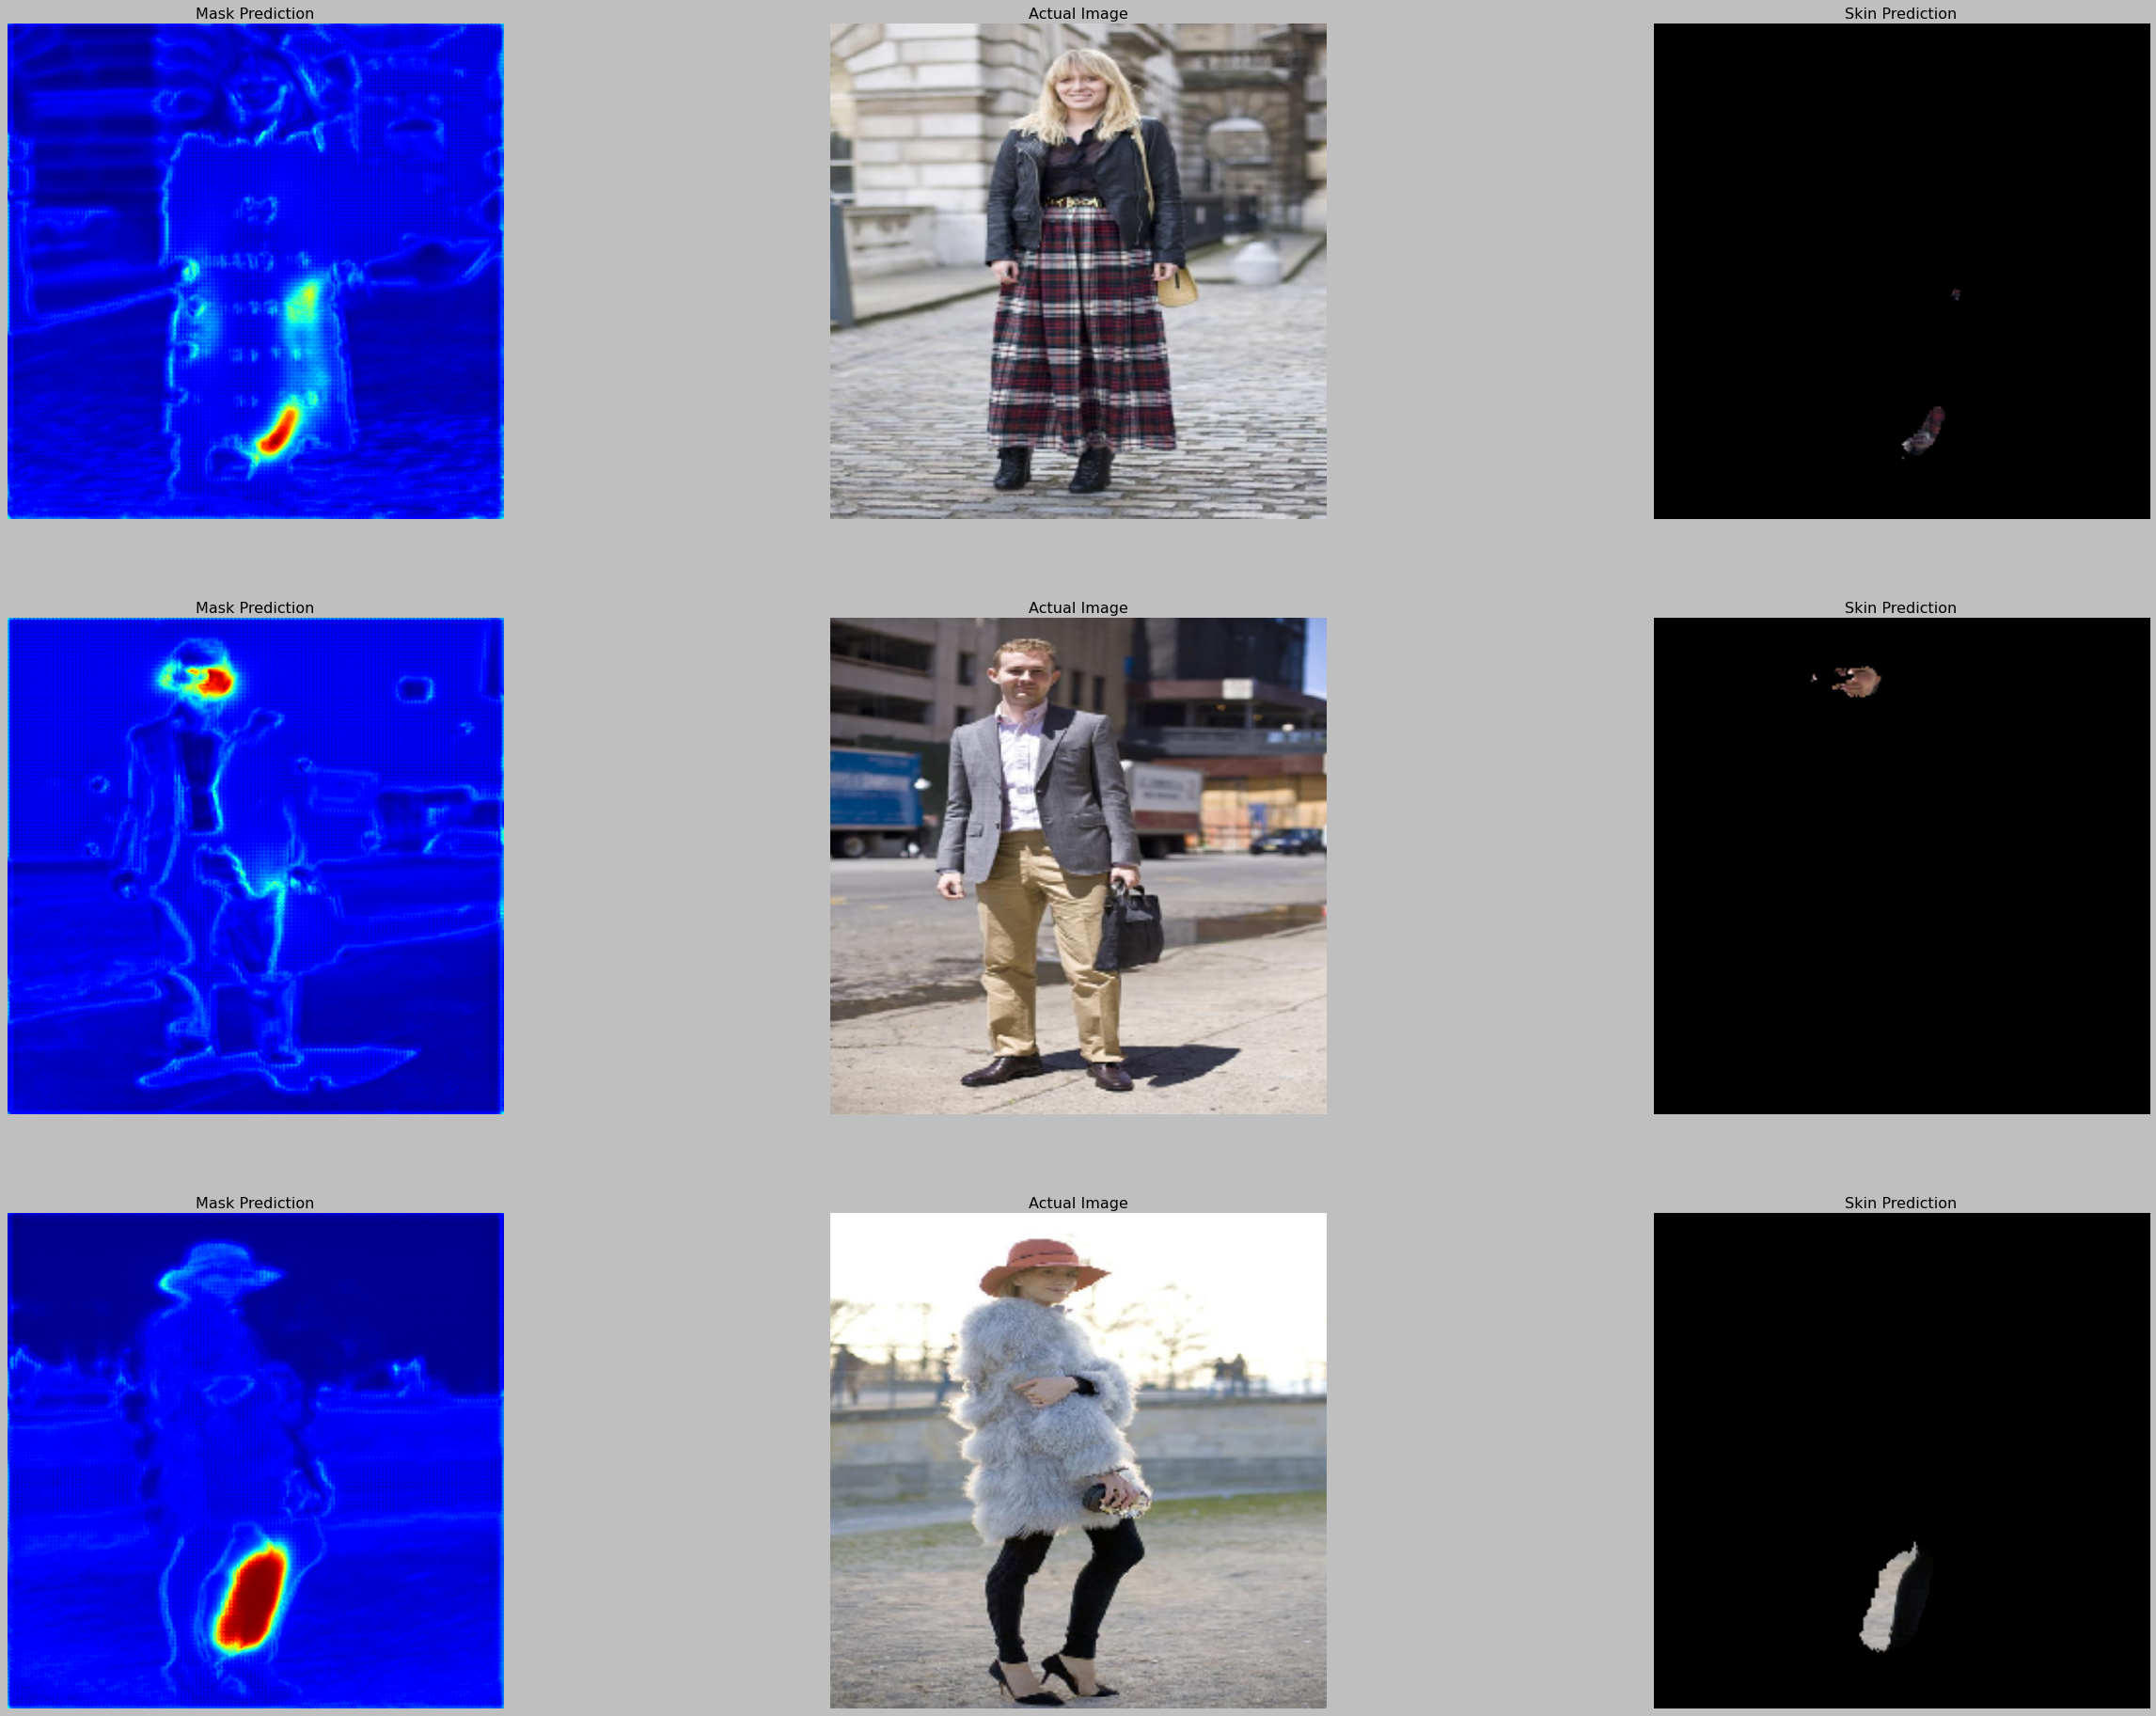

In [ ]:
# select a validation data batch
# img, mask = next(iter(val))
index = 4
img = img[:index]
mask = mask[:index]


fig,ax = plt.subplots(index-1, 3, figsize=(40, 28))

# mask = test_y[:5]
# img = test_X[:5]
# make prediction
pred = model.predict(img)
k = 0
for i in pred:
    # plot the predicted mask
    # plt.subplot(4,4,1+k)

    # plt.imshow(i,cmap='jet')
    # plt.axis('off')
    # plt.title('Prediction')
    ax[k, 0].imshow(i, cmap='jet')
    ax[k, 0].axis('off')
    ax[k, 0].set_title('Mask Prediction')
    
    
    # plot the actual image
    # plt.subplot(4,4,3+k)
    # plt.imshow(img[k])
    # plt.axis('off')
    # plt.title('Actual Image')
    ax[k, 1].imshow(img[k])
    ax[k, 1].axis('off')
    ax[k, 1].set_title('Actual Image')


    pred_thresh = np.where(i > 0.5, 1, 0)
    original_image = img[k]
    skin_pred = np.multiply(pred_thresh, original_image)
    # plt.subplot(4,4,4+k)
    # plt.imshow(skin_pred)
    # plt.axis('off')
    # plt.title('Skin Prediction')
    ax[k, 2].imshow(skin_pred)
    ax[k, 2].axis('off')
    ax[k, 2].set_title('Skin Prediction')
    
    
    k += 1







# Again the main purpose this notebook is to show, how to use the different loss functions in multiclass segmentation problem, so achieving higher mean-iou is not the purpose.
# 
# Here I used only 100 images, and trained the u-net only up to 10 epochs. It is obvious that using higher epoch and the entire dataset will give me results.